In [2]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

In [80]:
import tensorflow as tf

# prosess

In [81]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
#IMAGE_HEIGHT , IMAGE_WIDTH = 170, 170
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
#IMAGE_HEIGHT, IMAGE_WIDTH = 50, 50
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = ""
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["noFight", "fight"]


In [83]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the Grayscale Frame to fixed height and width.
        resized_frame = cv2.resize(gray_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
        
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list


In [84]:
def create_dataset():
    

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Ignore non-video files (e.g., .DS_Store)
            if not file_name.endswith(('.mp4', '.avi', '.mkv', '.mov')):
                continue
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels) 

    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [85]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: noFight
Extracting Data of Class: fight


In [86]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [87]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

In [4]:
from tensorflow.keras.layers import BatchNormalization, Dropout

def create_improved_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation='relu')))
    model.add(BatchNormalization())
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, dropout=0.5))  # Adjust dropout for LSTM layer

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model


In [89]:
model = create_LRCN_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeD  (None, 30, 64, 64, 32)    320       
 istributed)                                                     
                                                                 
 time_distributed_37 (TimeD  (None, 30, 32, 32, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_38 (TimeD  (None, 30, 32, 32, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_39 (TimeD  (None, 30, 16, 16, 64)    0         
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, 30, 16, 16, 128)  

In [90]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [91]:
def lr_schedule(epoch, lr):
    if epoch % 5== 0 and epoch > 0:
        lr = lr * 0.9
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
optimizer = Adam(learning_rate=0.001)

In [92]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_training_history = model.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True, validation_split=0.25, callbacks=[early_stopping_callback, lr_scheduler])

Epoch 1/70
69/69 [==============================] - 53s 727ms/step - loss: 0.6306 - accuracy: 0.6377 - val_loss: 0.6185 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 2/70
69/69 [==============================] - 50s 721ms/step - loss: 0.4889 - accuracy: 0.7065 - val_loss: 0.5893 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 3/70
69/69 [==============================] - 49s 709ms/step - loss: 0.5139 - accuracy: 0.7138 - val_loss: 0.6113 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 4/70
69/69 [==============================] - 72s 1s/step - loss: 0.4477 - accuracy: 0.7210 - val_loss: 0.5661 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 5/70
69/69 [==============================] - 59s 848ms/step - loss: 0.4478 - accuracy: 0.7428 - val_loss: 0.5861 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 6/70
69/69 [==============================] - 59s 861ms/step - loss: 0.4276 - accuracy: 0.7899 - val_loss: 0.5936 - val_accuracy: 0.7391 - lr: 9.0000e-04
Epoch 7/70
69/69 [==============================] - 57s 832ms/s

In [93]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

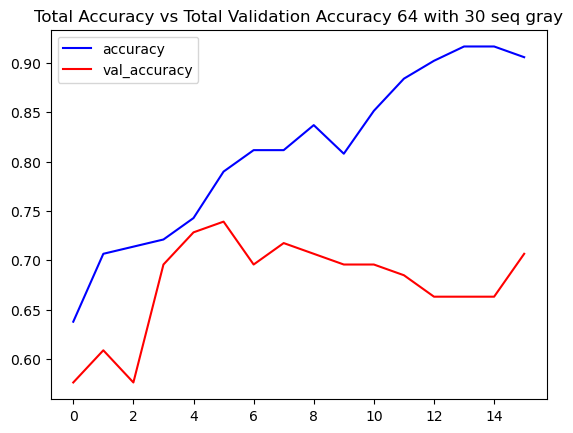

In [94]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy 64 with 30 seq gray')

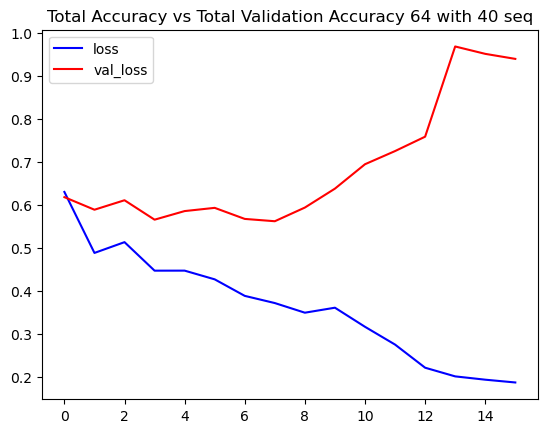

In [95]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Accuracy vs Total Validation Accuracy 64 with 40 seq')

In [96]:
# Calculate Accuracy On Test Dataset
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 133ms/step
Accuracy = 79.67479674796748


In [97]:
from tensorflow.keras.models import save_model

In [98]:
#model 128 and 70 epochs has accuracy 74.79
#model 50 and 70 epochs has accuracy 76.42
#model 64 and 19 epochs has accuracy 75.6
#model 64 and 16 epochs has accuracy gray 79.6

model.save('model64_seq30_adblr_gray2.h5')

/Users/lanaal-dabbas/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Webcam

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["noFight", "fight"]

# Load the trained LRCN model
model = load_model("model64_seq30_adblr_gray.h5")

# Open a connection to the webcam (camera index 0 by default)
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize and normalize the frame
    processed_frame = cv2.resize( gray_frame, (IMAGE_HEIGHT, IMAGE_WIDTH)) / 255.0

    # Add the processed frame to a sequence
    frames_sequence = np.repeat(np.expand_dims(processed_frame, axis=0), SEQUENCE_LENGTH, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(np.expand_dims(frames_sequence, axis=0))

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Get the predicted class label
    predicted_class_label = CLASSES_LIST[predicted_class_index]

    # Display the webcam feed with the predicted label
    cv2.putText(frame, f"Prediction: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # If a fight is detected, draw a red rectangle
    if predicted_class_label == "fight":
        h, w, _ = frame.shape
        cv2.rectangle(frame, (0, 0), (w, h), (0, 0, 255), 9)

    cv2.imshow("Webcam Feed", frame)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 83ms/step


KeyboardInterrupt: 

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["noFight", "fight"]

# Load the trained LRCN model
model = load_model("model64_seq30_adblr_gray.h5")

# Open a connection to the webcam (camera index 0 by default)
cap = cv2.VideoCapture(0)

# Initialize an empty list to store frames
frames_sequence = []

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize and normalize the frame
    processed_frame = cv2.resize(gray_frame, (IMAGE_HEIGHT, IMAGE_WIDTH)) / 255.0

    # Add the processed frame to the list
    frames_sequence.append(processed_frame)

    # Limit the list to 30 frames
    frames_sequence = frames_sequence[-SEQUENCE_LENGTH:]

    # Make a prediction using the trained model when the sequence is complete
    if len(frames_sequence) == SEQUENCE_LENGTH:
        frames_sequence_array = np.array(frames_sequence)
        frames_sequence_array = np.expand_dims(frames_sequence_array, axis=0)
        prediction = model.predict(frames_sequence_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class_label = CLASSES_LIST[predicted_class_index]

        # Display the webcam feed with the predicted label
        cv2.putText(frame, f"Prediction: {predicted_class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # If a fight is detected, draw a red rectangle
        if predicted_class_label == "fight":
            h, w, _ = frame.shape
            cv2.rectangle(frame, (0, 0), (w, h), (0, 0, 255), 9)

    cv2.imshow("Webcam Feed", frame)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 71ms/step


KeyboardInterrupt: 